# Спрос на рейсы авиакомпании

Для российской авиакомпании F9, выполняющей внутренние пассажирские перевозки, важно понять предпочтения пользователей, покупающих билеты на разные направления.

Нам предстоит изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие культурные фестивали.

У нас есть файлы с результатами запросов из предыдущих заданий.

**query_1.csv** — результат первого запроса. В нём содержится такая информация:

- *model* — **модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов *model* в сентябре 2018 года.

**query_3.csv** — результат третьего запроса. В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город (*city*) за день в сентябре 2018 года.


Код запроса `query_1`:

```sql

SELECT
    aircrafts.model AS model,
    COUNT(flights.flight_id) AS flights_amount
FROM
    aircrafts INNER JOIN flights ON aircrafts.aircraft_code = flights.aircraft_code
WHERE
    flights.departure_time :: DATE >= '2018-09-01'
    AND flights.departure_time :: DATE <= '2018-09-30'
GROUP BY
    aircrafts.model

```

Код запроса `query_3`:

```sql

SELECT
    sub.town AS city,
    AVG(sub.cnt) AS average_flights
FROM
    (SELECT
         EXTRACT(DAY FROM flights.arrival_time :: DATE) as date,
         airports.city AS town,
         COUNT(flights.flight_id) AS cnt
     FROM
         flights INNER JOIN airports ON airports.airport_code = flights.arrival_airport
     WHERE
         EXTRACT(MONTH FROM flights.arrival_time :: DATE) = 8
         AND EXTRACT(YEAR FROM flights.arrival_time :: DATE) = 2018
     GROUP BY
         date,
         town
    ) AS sub
GROUP BY
    city

```

## Аналитика

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Импортируем данные и изучим их содержимое.

In [2]:
query1 = pd.read_csv('/datasets/query_1.csv')
query3 = pd.read_csv('/datasets/query_3.csv')

In [3]:
query1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [4]:
query1

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


В первой таблице содержатся 2 столбца и 8 строк. Первый столбец строкового типа содержит модель самолета, а второй целочисленного типа количество рейсов этой модели в сентябре 2018 года.

In [5]:
query1.describe()

,flights_amount
count,8.000000
mean,2035.625000
std,1965.203947
min,300.000000
25%,605.250000
50%,795.000000
75%,4250.250000
max,4557.000000


Описание данных содержит информацию о том, что среднее значение сильно смещено вправо относительно медианы. Это является следствием того, что данные представлены долько для 8 объектов.

In [6]:
query3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [7]:
query3.head()

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


In [8]:
query3.describe()

,average_flights
count,101.000000
mean,5.494189
std,13.119790
min,1.000000
25%,2.000000
50%,3.000000
75%,5.870968
max,129.774194


В таблице по третьему запросу содержатся 2 столбца и 101 строка. Один столбец строкового типа с названием города, второй - вещественного типа со средним количеством рейсов за сентябрь 2018, прибывающих в конкретный город. Так как количество рейсов не может быть дробным округлим все числа до целого значения.

In [9]:
query3['average_flights'] = round(query3['average_flights']).astype('int16')

In [10]:
query3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null int16
dtypes: int16(1), object(1)
memory usage: 1.1+ KB


In [11]:
query3.head()

,city,average_flights
0,Абакан,4
1,Анадырь,1
2,Анапа,2
3,Архангельск,5
4,Астрахань,2


In [12]:
query3.describe()

,average_flights
count,101.000000
mean,5.485149
std,13.141243
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,130.000000


Описание втоой таблицы говорит о том, что среднее значение отличается от медианы почти вдвое и смещено вправо. Это связано с наличием объектов с высокими значениями среднего количества полетов.

Выберем топ-10 городов по количеству рейсов.

In [13]:
(query3
 .sort_values('average_flights', ascending=False)
 .reset_index(drop=True)
 .head(10))

,city,average_flights
0,Москва,130
1,Санкт-Петербург,31
2,Новосибирск,17
3,Красноярск,12
4,Екатеринбург,11
5,Ростов-на-Дону,10
6,Сочи,10
7,Ульяновск,10
8,Пермь,10
9,Брянск,10


Как видно из получившейся таблицы безусловным лидером по ежедневному среднему количеству рейсов за сентябрь 2018 года является Москва, далее по списку идет Санкт-Петербург с результатом в 10 раз меньше Москвы, а на третьем месте стоит Новосибирск, в 2 раза отстающий от Санкт-Петербурга. В сентябре 2018 люди предпочитали Москву другим городам России.

Построим диаграмму, показывающую сколько рейсов совершили различные модели самолетов за сентябрь 2018 года.

Text(0.5, 0, 'Модель')

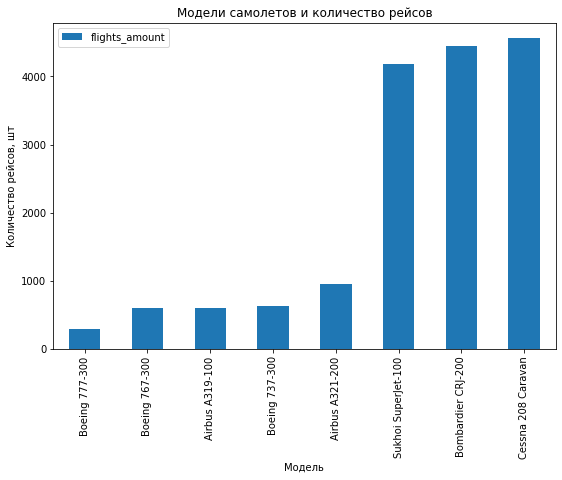

In [14]:
(query1
 .sort_values('flights_amount')
 .plot(x='model', kind='bar', figsize=(9, 6)))
plt.title('Модели самолетов и количество рейсов')
plt.ylabel('Количество рейсов, шт')
plt.xlabel('Модель')

Из диаграммы видно, что с небольшим разрывом первые три места занимают Cessna 208 Caravan, Bombardier CRJ-200 и Sukhoi SuperJet-100, а Боинги и Аэробусы совершали в разы меньше полетов.

Построим диаграмму, сообщающую столько рейсов в среднем совершалось ежедневно в различные города в сентябре 2018 года.

Text(0.5, 0, 'Город')

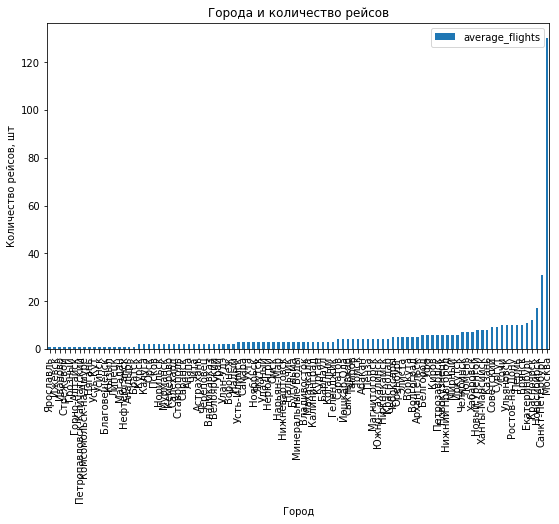

In [15]:
(query3
 .sort_values('average_flights')
 .plot(x='city', kind='bar', figsize=(9, 6)))
plt.title('Города и количество рейсов')
plt.ylabel('Количество рейсов, шт')
plt.xlabel('Город')

По диаграмме видно, что пассажиры особенно предпочитали всего несколько городов. В целом распределение рейсов по городам одинаковое, если не считать пары исключений. На меньшем масштабе посмотрим, какие это города.

Text(0.5, 0, 'Город')

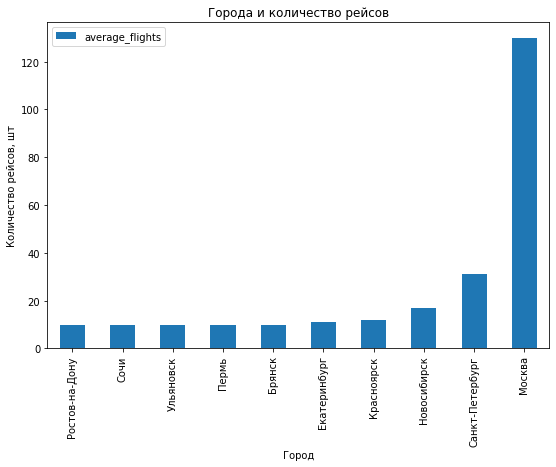

In [16]:
(query3
 .sort_values('average_flights', ascending=False)
 .reset_index(drop=True)
 .head(10)
 .sort_values('average_flights')
 .plot(x='city', kind='bar', figsize=(9, 6)))
plt.title('Города и количество рейсов')
plt.ylabel('Количество рейсов, шт')
plt.xlabel('Город')

Больше всего пассажиры авиакомпании стремились попасть в Москву. Так же они были не против слетать в Санкт-Петербург и Новосибирск. Остальные города не пользовались у пассажиров особым интересом.

### Вывод

В проекте был проведен анализ результатов двух запросов. Был изменен столбец третьего запроса со средними значениями ежедневных прилетов в различные города, а именно совершено округление и преобразование в целочисленный тип данных. Далее на основе анализа построенных диаграмм, были получены следующие результаты:

    - Больше всего рейсов совершалось на Cessna 208 Caravan, Bombardier CRJ-200 и Sukhoi SuperJet-100, а остальные типы воздушных судов использовались куда менее активно, что может быть связано с небольшим количеством пассажиров, желающих совершить перелет, а также с дальностью перелетов между регионами.
    - Медианное значение ежедневных рейсов, прибывающих в город, по России равняется 3 перелетам.
    - Москва это город, в который пассажиры хотели попасть больше всего. Санкт-Петербург по сравнению с медианой и средним по России тоже показал хорошие результаты по предпочтению пассажирами.